In [3]:
import pandas as pd
import numpy as np
import numpy.linalg as la

In [4]:
import pickle

with open('data/Portland_D1_cleaned_votekit_pref_profile.pkl', 'rb') as file:
    profile = pickle.load(file)

In [5]:
profile

Profile has been cleaned
Profile contains rankings: True
Maximum ranking length: 6
Profile contains scores: False
Candidates: ('Uncertified Write In', 'Peggy Sue Owens', 'Candace Avalos', 'Doug Clove', 'Deian Salazar', 'Terrence Hayes', 'Michael (Mike) Sands', 'Thomas Shervey', 'Jamie Dunphy', 'Noah Ernst', 'Timur Ender', 'Joe Furi', 'Joe Allen', 'Cayle Tern', 'Steph Routh', 'David Linn', 'Loretta Smith')
Candidates who received votes: ('Candace Avalos', 'Cayle Tern', 'Jamie Dunphy', 'Loretta Smith', 'Steph Routh', 'Doug Clove', 'Michael (Mike) Sands', 'David Linn', 'Timur Ender', 'Deian Salazar', 'Peggy Sue Owens', 'Joe Allen', 'Joe Furi', 'Terrence Hayes', 'Noah Ernst', 'Thomas Shervey', 'Uncertified Write In')
Total number of Ballot objects: 19872
Total weight of Ballot objects: 42871.0

In [6]:
from votekit.elections import STV
from votekit.utils import first_place_votes


# 3 seat election
election = STV(profile, m=3)
print("Winners in order of election")
i=0
for cand_set in election.get_elected():
    for cand in cand_set:
        i+=1
        print(i, cand)

# threshold
print("\nThreshold: ", election.threshold, "\n")

fpv_dict = first_place_votes(profile)
cands_sorted_by_fpv = sorted(zip(fpv_dict.keys(), fpv_dict.values()), # creates a list of tuples, (name, fpv)
                                reverse=True,  #decreasing order
                                key = lambda x: x[1], # sort by second element of tuple, which is fpv)
                                    )

print("Candidates in decreasing order of first place votes.\n")
for cand, fpv in cands_sorted_by_fpv:
    print(cand, fpv)

Winners in order of election
1 Candace Avalos
2 Loretta Smith
3 Jamie Dunphy

Threshold:  10718 

Candidates in decreasing order of first place votes.

Candace Avalos 8297.0
Loretta Smith 5586.0
Jamie Dunphy 5064.0
Noah Ernst 4052.0
Terrence Hayes 3975.0
Steph Routh 3894.0
Timur Ender 3550.0
Doug Clove 1698.0
Peggy Sue Owens 1266.0
David Linn 1111.0
Joe Allen 978.0
Michael (Mike) Sands 952.0
Deian Salazar 720.0
Cayle Tern 711.0
Thomas Shervey 385.0
Joe Furi 355.0
Uncertified Write In 277.0


In [17]:
from votekit import matrices
from votekit.utils import mentions

def make_boost(profile, candidates, diagonal_zeros = True):
    total_ballots = len(profile.ballots)
    boost = matrices.boost_matrix(profile, candidates)
    if diagonal_zeros:
        for i, candidate in enumerate(candidates):
            boost[i,i] = 0
    else:
        for i, candidate in enumerate(candidates):
            boost[i,i] = 1 - mentions[candidate] / total_ballots
    return boost
        

In [18]:
boost = make_boost(profile, profile.candidates)

In [19]:
import matplotlib.pyplot as plt

def show_matrix(M,title=None):
    fig, ax = plt.subplots()
    if title:
        plt.title(title)
    img = ax.imshow(M)
    fig.colorbar(img)
    ax.set_aspect('auto')
    plt.show()

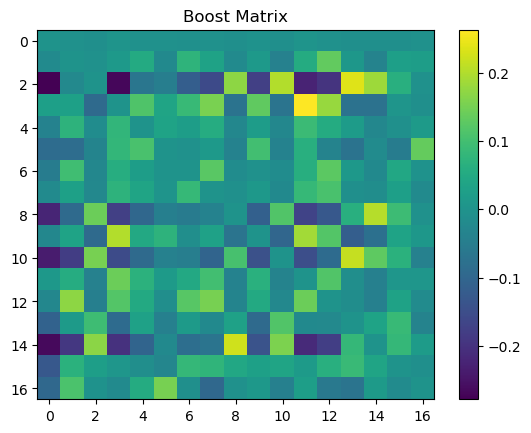

In [20]:
show_matrix(boost, title="Boost Matrix")

In [21]:
import random
from votekit.utils import mentions

candidate_mentions = mentions(profile)
candidates = profile.candidates
candidates_mentions = sorted(candidates, key = (lambda x : candidate_mentions[x]), reverse=True)
print(candidates_mentions)
candidates_manual = [
 'Candace Avalos',
 'Steph Routh',
 'Jamie Dunphy',
 'Timur Ender',
 'David Linn',
 'Cayle Tern',
 'Loretta Smith',
 'Terrence Hayes',
 'Noah Ernst',
 'Doug Clove',
 'Deian Salazar',
 'Michael (Mike) Sands',
 'Joe Allen',
 'Joe Furi',
 'Peggy Sue Owens',
 'Thomas Shervey',
 'Uncertified Write In']

candidates_random = random.sample(candidates, len(candidates))


['Candace Avalos', 'Steph Routh', 'Jamie Dunphy', 'Loretta Smith', 'Timur Ender', 'Terrence Hayes', 'Noah Ernst', 'David Linn', 'Cayle Tern', 'Doug Clove', 'Deian Salazar', 'Michael (Mike) Sands', 'Joe Allen', 'Joe Furi', 'Peggy Sue Owens', 'Thomas Shervey', 'Uncertified Write In']


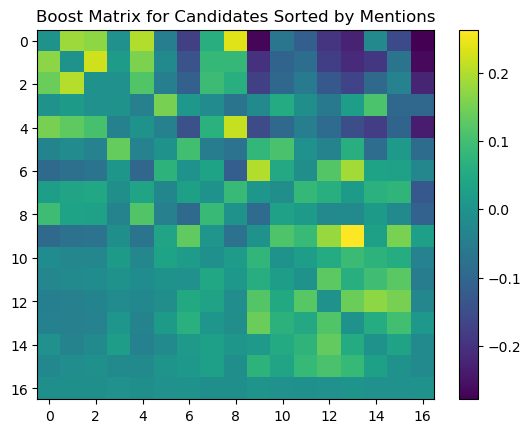

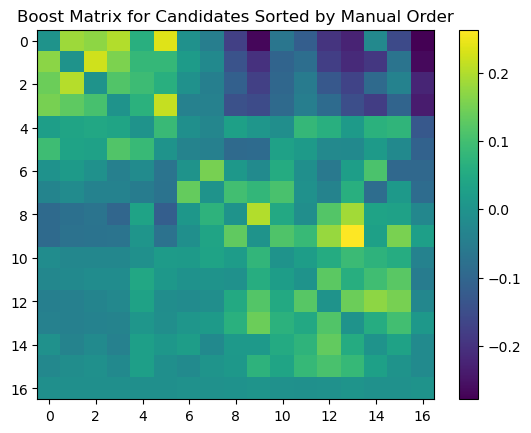

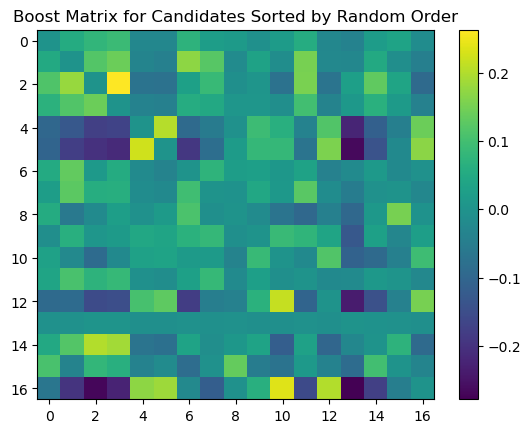

In [22]:
boost_mentions = make_boost(profile, candidates_mentions)
boost_manual = make_boost(profile, candidates_manual)
boost_random = make_boost(profile, candidates_random)
show_matrix(boost_mentions, title="Boost Matrix for Candidates Sorted by Mentions")
show_matrix(boost_manual, title="Boost Matrix for Candidates Sorted by Manual Order")
show_matrix(boost_random, title="Boost Matrix for Candidates Sorted by Random Order")

In [25]:
import itertools


def partitions(n, k):
    for c in itertools.combinations(range(n+k-1), k-1):
        yield [b-a-1 for a, b in zip((-1,)+c, c+(n+k-1,))]

def partition_to_mask_matrix(partition):
    n = sum(partition)
    partition = [0] + partition
    partition = np.cumsum(partition)
    mask_matrix = np.zeros((n,n))
    for i in range(len(partition)-1):
        lower_limit = partition[i]
        upper_limit = partition[i+1]
        indicator_vector = np.zeros(n)
        for j in range(lower_limit, upper_limit):
            indicator_vector[j] = 1
        mask_matrix += np.outer(indicator_vector, indicator_vector)
    return mask_matrix


def blockify(matrix, num_blocks):
    n = matrix.shape[0]
    max_value = -np.inf
    max_partition = None
    for partition in partitions(n,num_blocks):
        mask_matrix = partition_to_mask_matrix(partition)
        value = np.trace(mask_matrix @ matrix)
        if value >= max_value:
            max_value = value
            max_partition = partition
    return max_value, max_partition


In [26]:
mentions_value, mentions_partition = blockify(boost_mentions, 4)
print(f"Mentions value: {mentions_value}, partition: {mentions_partition}")
manual_value, manual_partition = blockify(boost_manual, 4)
print(f"Manual value: {manual_value}, partition: {manual_partition}")
random_value, random_partition = blockify(boost_random, 4)
print(f"Random value: {random_value}, partition: {random_partition}")

Mentions value: 7.039427352339445, partition: [5, 11, 1, 0]
Manual value: 8.801220558396711, partition: [6, 10, 1, 0]
Random value: 3.0544729402691218, partition: [4, 9, 3, 1]
